### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 21 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 21 декабря, -4 балла после 08:30 28 декабря, -6 баллов после 08:30 04 янва, -8 баллов после 08:30 11 января.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут (t - номер алгоритма)

1) $$y_{ti} =2(y_i - a_{t-1}(x_i))$$
2) $$y_{ti} =y_iexp(-y_ia_{t-1}(x_i))$$
3) $$ y_{ti} = \frac{y_iexp(-y_ia_{t-1}(x_i))}{1+exp(-y_ia_{t-1}(x_i))}$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [5]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle

In [6]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.1, n_estimators=100, colsample=0.5, subsample=0.5, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучении одного алгоритма
        colsample -- процент рандомных объектов при обучении одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.trees = []
        self.features = []
    
    def target(self, y, a):
        if self.loss == 'mse':
            return 2 * (y - a)
        if self.loss == 'log':
            return y * np.exp(- y * a) / (1 + np.exp(- y * a))
        return y * np.exp(- y * a)
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        self.X = np.array(X)
        self.y = np.array(y)
        if init_model is None:
            a = np.mean(y) * np.ones([y.shape[0]])
        else: 
            model = init_model(*self.args, **self.kwargs)
            model.fit(X, y)
            self.trees.append(model)
            self.features.append(list(range(X.shape[1])))
            a = np.array(model.predict(X))
        for t in range(self.n_estimators):
            col = shuffle(list(range(X.shape[1])), random_state=0)
            col = col[:round(X.shape[1] * self.colsample)]
            self.features.append(col)
            X_f = X[:, col]
            sub = shuffle(list(range(X.shape[0])), random_state=0)
            sub = sub[:round(X.shape[0] * self.subsample)]
            X_sample = X_f[sub, :] 
            y_sample = y[sub]
            a_sample = a[sub]  
            model = base_model(*self.args, **self.kwargs)
            model.fit(X_sample, self.target(y_sample, a_sample))
            self.trees.append(model)
            a = a + self.learning_rate * np.asarray(model.predict(X_f))
            
        
    def predict(self, X):
        # Ваш код здесь
        a = np.ones([X.shape[0]]) * np.mean(self.y)
        for t in range(len(self.trees)):
            a += self.learning_rate * self.trees[t].predict(X[:, self.features[t]])
        return np.round(a)



In [89]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [90]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [91]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [8]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [9]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [94]:
accuracy = []
for n in range(1, 150):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    my_clf = MyGradientBoostingClassifier(n_estimators=n)
    my_clf.fit(X_train, y_train)
    accuracy.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

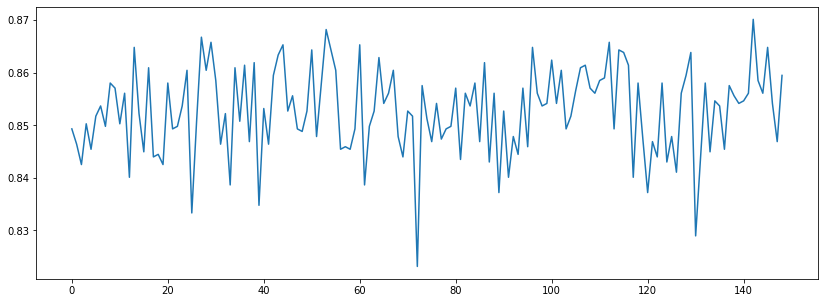

In [97]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,5))
plt.plot(accuracy)
plt.show()

In [98]:
np.argmax(accuracy)

142

In [103]:
from itertools import product

In [104]:
grid_params = product(
    ('mse', 'exp', 'log'), # loss
    (0.25, 0.5, 0.75, 1), # subsample
    (0.25, 0.5, 0.75, 1), # colsample
    (0.1, 0.3, 0.5)) # learning_rate 
n = 142

In [105]:
params = []
accur = []
for loss, sub, col, lr in grid_params:
    params.append([loss, sub, col, lr, n])
    clf = MyGradientBoostingClassifier(loss =loss, learning_rate=lr,
                                       n_estimators=n, colsample=col,
                                       subsample=sub)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                        stratify=y)
    clf.fit(X_train, y_train)
    accur.append(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

In [106]:
np.max(accur)

0.873062015503876

In [107]:
params[np.argmax(accur)]

['mse', 0.5, 0.5, 0.5, 142]

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [7]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
N = 10

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
my_clf = MyGradientBoostingClassifier('mse', 0.5, 142, 0.5, 0.5, N)
my_clf.fit(X_train, y_train, RandomForestRegressor)
print("1:", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1: 0.8905038759689923


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
a = np.ones([X_test.shape[0]]) * np.mean(y_train)
for i in range(N):
    indices = np.random.randint(0, len(y_train), (1, len(y_train)))[0]
    X_samples = X_train[indices, :]
    y_samples = y_train[indices]
    my_clf = MyGradientBoostingClassifier('mse', 0.5, 142, 0.5, 0.5)
    my_clf.fit(X_samples, y_samples, DecisionTreeRegressor)
    a += my_clf.predict(X_test)
a = np.round(a / N)
print("2:", accuracy_score(y_pred=a, y_true=y_test))

2: 0.8885658914728682


Качество улучшилось в обеих стратегиях.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
my_clf = MyGradientBoostingClassifier('mse', 0.5, 142, 0.5, 0.5)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=RandomForestRegressor)
print("RandomForest: ", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
my_clf = MyGradientBoostingClassifier('mse', 0.5, 142, 0.5, 0.5)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=SVC)
print("SVC: ", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
my_clf = MyGradientBoostingClassifier('mse', 0.5, 142, 0.5, 0.5)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=LogisticRegression)
print("LogisticRegression: ", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

RandomForest:  0.8192829457364341
SVC:  0.8648255813953488


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression:  0.7374031007751938


Не удалось. Наверное, константа в инициализаторе хороша.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

